In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt
import torch

from settings import COLON_CANCER_SETTINGS, MNIST_SETTINGS
from model import construct_PPNet
from save import load_model_from_train_state

from datasets.mnist_dataset import MnistBags

In [3]:
device = torch.device('cuda')

In [4]:
config = MNIST_SETTINGS

In [5]:
load_model_dir = './saved_models/mnist.plaster.2021-03-03T16:04:24.365208'
load_model_name = '40.push.best.124.92.40.pck'

load_model_path = os.path.join(load_model_dir, load_model_name)

ppnet = construct_PPNet(base_architecture=config.base_architecture,
                        pretrained=False, 
                        img_size=config.img_size,
                        prototype_shape=config.prototype_shape,
                        num_classes=config.num_classes,
                        prototype_activation_function=config.prototype_activation_function,
                        add_on_layers_type=config.add_on_layers_type,
                        batch_norm_features=config.batch_norm_features)

print('load model from ' + load_model_path)
load_model_from_train_state(load_model_path, ppnet)

ppnet = ppnet.to(device)

load model from ./saved_models/mnist.plaster.2021-03-03T16:04:24.365208/40.push.best.124.92.40.pck


In [6]:
# confirm prototype class identity
epoch_number_str = re.search(r'\d+', load_model_name).group(0)
load_img_dir = os.path.join(load_model_dir, 'img')

prototype_info = np.load(os.path.join(load_img_dir, 'epoch-'+epoch_number_str, 'bb'+epoch_number_str+'.npy'))
prototype_img_identity = prototype_info[:, -1]

print('Prototypes are chosen from ' + str(len(set(prototype_img_identity))) + ' number of classes.')
print('Their class identities are: ' + str(prototype_img_identity))

Prototypes are chosen from 2 number of classes.
Their class identities are: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


In [11]:
def metric_entropy(attention_vector):
    return -sum(attention_vector * np.nan_to_num(np.log2(attention_vector), neginf=1e-9)) / len(attention_vector)

def generate_entropy(test_loader):
    true_positive_entropy = []
    true_negative_entropy = []
    false_neg_entropy = []
    false_pos_entropy = []

    for bag, label in test_loader:
        bag = bag.squeeze(0)
        
        with torch.no_grad():
            ppnet.eval()
            
            images_test = bag.to(device)
            labels_test = label.to(device)

            logits, min_distances, attention = ppnet(images_test) # function forward in model.py should return logits, min_distances, A

            conv_output, distances = ppnet.push_forward(images_test)
            prototype_activations = ppnet.distance_2_similarity(min_distances)
            prototype_activation_patterns = ppnet.distance_2_similarity(distances)
            if ppnet.prototype_activation_function == 'linear':
                prototype_activations = prototype_activations + max_dist
                prototype_activation_patterns = prototype_activation_patterns + max_dist

            tables = []
            for i in range(logits.size(0)):
                tables.append((torch.argmax(logits, dim=1)[i].item(), labels_test[i].item()))
                # print(str(i) + ' ' + str(tables[-1]))

            idx = 0
            predicted_cls = tables[idx][0]
            correct_cls = tables[idx][1]    
            # print('Predicted: ' + str(predicted_cls))
            # print('Actual: ' + str(correct_cls))
            at = attention.detach().cpu().numpy().flatten()
            at_s = np.interp(at, (at.min(), at.max()), (0, 1))

            if predicted_cls == correct_cls:
                if predicted_cls == 0:
                    true_negative_entropy.append(metric_entropy(at_s))
                else:
                    true_positive_entropy.append(metric_entropy(at_s))
            else:
                if correct_cls == 1 and predicted_cls == 0:
                    false_neg_entropy.append(metric_entropy(at_s))
                else:
                    false_pos_entropy.append(metric_entropy(at_s))
    
    return true_positive_entropy, true_negative_entropy, false_neg_entropy, false_pos_entropy

In [12]:
target_numbers_in_pos_bag_mean = [0.1, 0.5, 1]
target_numbers_in_pos_bag_std = [0, 0, 0]

/home/jkraus/miniconda3/envs/deepfake/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  


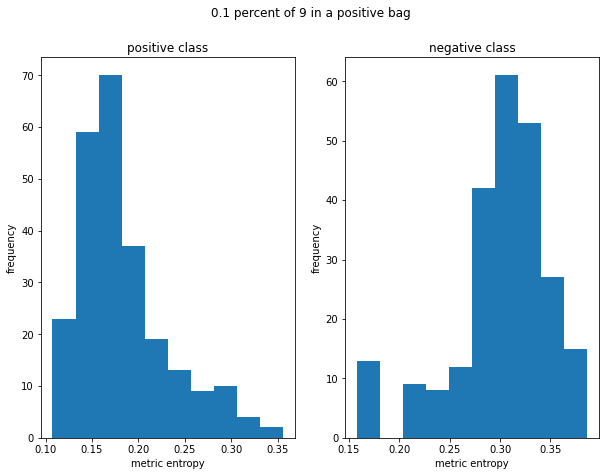

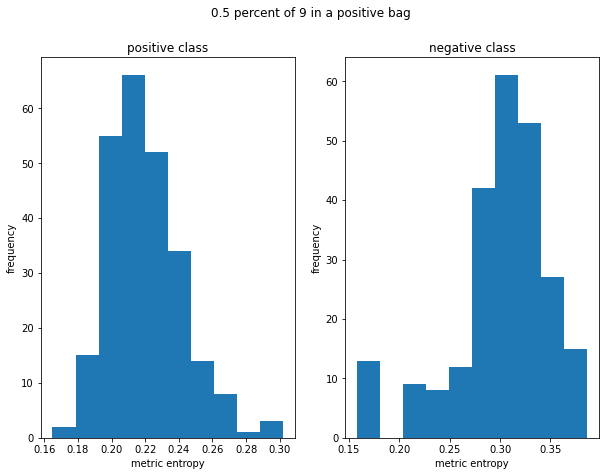

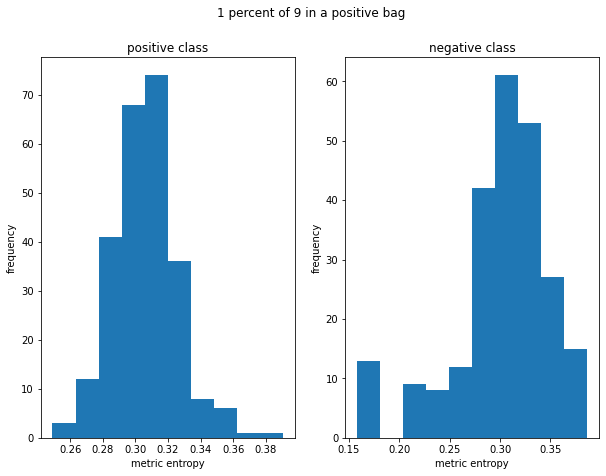

In [13]:
for a, b in zip(target_numbers_in_pos_bag_mean, target_numbers_in_pos_bag_std):
    ds_test = MnistBags(train=False, 
                        target_numbers_in_pos_bag_mean=a, 
                        target_numbers_in_pos_bag_std=b)

    test_loader = torch.utils.data.DataLoader(
        ds_test, batch_size=None, 
        shuffle=True,
        num_workers=0,
        pin_memory=False)
    
    true_positive_entropy, true_negative_entropy, false_neg_entropy, false_pos_entropy = generate_entropy(test_loader)

    fig, axs = plt.subplots(1, 2, figsize=(10, 7))

    axs[0].hist(true_positive_entropy);
    axs[0].set_title('positive class')
    axs[0].set_xlabel('metric entropy')
    axs[0].set_ylabel('frequency')

    axs[1].hist(true_negative_entropy);
    axs[1].set_title('negative class')
    axs[1].set_xlabel('metric entropy')
    axs[1].set_ylabel('frequency')

    fig.suptitle(f'{a} percent of 9 in a positive bag')
    plt.show()